# Building Good Training Sets - Data PreProcessing

The quality of the data and the amount of useful information that it contains are key factors that determine how well a machine learning algorithm can learn.  Therefore, it is absolutely critical that we make sure to examine and preprocess a dataset before we feed it to a learning algorithm.  In this chapter, we will look at the essential data preprocessing techniques that will help us build good machine learning models.

The topics that we will cover in this chapter are as follows:

- Removing and imputing missing values from the dataset
- Getting categorical data into shape for machine learning algorithms
- Selecting relevant features for the model construction

## Identifying missing values in tabular data

Let us create a simple example data frame from a **Comma-Separated Values (CSV)** file to get a better grasp of the problem:

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from io import StringIO

csv_data = \
'''
A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,
'''
df = pd.read_csv(StringIO(csv_data))
print(df)

      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN


The ```StringIO``` function allows us to read the string assigned to ```csv_data``` into a pandas ```DataFram``` as if it was a regular CSV file on our hard drive.

For much larger datasets, we could do something like:

In [3]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

Remember that we can always access the underlying NumPy array of a ```DataFrame``` via the ```values``` attribute before we feed it into a scikit-learn estimator:

In [4]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

## Some examples of using the ```dropna``` method:

In [5]:
df.dropna(axis=0)  # i.e., we drop the row(s)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [6]:
df.dropna(axis=1)  # i.e., we drop the column(s)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [7]:
df.dropna(how='all')  # only drop the rows where all the columns are NaN.

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [8]:
df.dropna(thresh=4)  # drop the rows that have less than 4 values.

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [9]:
df.dropna(subset=['C'])  # drop the rows where NaN appears in the specified columns

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## Impurint missing values

One of the most common interpolation techniques is **mean imputation**, we we simply replace the missing value with the mean value of the entire feature column.  A convenient way to achieve this is by using the ```Imputer``` class from scikit-learn, as shown in the following code:

In [10]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
print(imputed_data)

[[ 1.   2.   3.   4. ]
 [ 5.   6.   7.5  8. ]
 [10.  11.  12.   6. ]]


If we'd changed the ```axis=0``` setting to ```axis=1```, we'd calculate the row means.  Other options for the ```strategy``` parameter include ```median```, or ```most_frequent```.

## Creating an example dataset containing categorical data

Before we explore different tecniques to handle categorical data, let's create a new ```DataFrame``` to illustrate the problem:

In [11]:
import pandas as pd
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
print(df)

   color size  price classlabel
0  green    M   10.1     class1
1    red    L   13.5     class2
2   blue   XL   15.3     class1


## Mapping Ordinal Features.

In the following simple example, let's assume that we know the numerical difference between features.
For example:
$$
XL = L + 1 = M + 2
$$

In [12]:
size_mapping = {
    'XL': 3,
    'L': 2,
    'M': 1
}

df['size'] = df['size'].map(size_mapping)
print(df)

   color  size  price classlabel
0  green     1   10.1     class1
1    red     2   13.5     class2
2   blue     3   15.3     class1


Suppose we want to transform the integer values back to the original string representations at a later stage:

In [13]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}

df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

## Encoding Class Labels

May machine learning libraries require that class labels are encoded as integer values.  It is considered good practice to provide class labels as integer arrays to avoid technical glitches.

In the following, we simply enumerate the class labels, starting at 0:

In [14]:
import numpy as np

class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
print(class_mapping)

{'class1': 0, 'class2': 1}


In [15]:
df['classlabel'] = df['classlabel'].map(class_mapping)
# We use the mapping dictionary to transform the class labels into integers.
print(np.unique(df['classlabel'].values))

[0 1]


In [16]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
print(df)
# Here we reverse the key-value pairs in the mapping dictionary.
# We map the converted class labels back to their original string representations.

   color  size  price classlabel
0  green     1   10.1     class1
1    red     2   13.5     class2
2   blue     3   15.3     class1


In [17]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
print(y)
# There is a convenient LabelEncoder class directly implemented in sklearn to achieve this.

[0 1 0]


In [18]:
class_le.inverse_transform(y)
# Note that we can use the inverse_transform method to transform the integer class labels
# back into their original string representations.

/home/henri/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['class1', 'class2', 'class1'], dtype=object)

## Performing one-hot encoding on nominal features

In one-hot encoding (ohe), the idea is to create a new dummy feature for each unique value in the nomial feature column.

In [19]:
X = df[['color', 'size', 'price']].values

pd.get_dummies(df[['price', 'color', 'size']])
# A very convenient way to create dummy features via OHE.
# get_dummies will only convert the string columns and leave all the other columns unchanged

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [20]:
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)
# Removing one feature from the OHE-array.
# We simply drop the first column by passing a True argument to the drop_first parameter.

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


## Partitioning a dataset into separate training and test sets.

In this section, we will prepare a new dataset, the **Wine** dataset.  After we have preprocessed the dataset, we will explore different techniques for feature selction to reduce the dimensionality of the dataset.

In [21]:
df_wine = pd.read_csv('/home/henri/stuff/machine_learning/sebastian_raschka/henris_coding/chapter_04/wine_data.txt',
                      header=None)

df_wine.columns = ['Class label',
                   'Alcohol',
                   'Malic acid',
                   'Ash',
                   'Alkalinity of ash',
                   'Magnesium',
                   'Total Phenols',
                   'Flavonoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color Intensity',
                   'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))

df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alkalinity of ash,Magnesium,Total Phenols,Flavonoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


A convenient way to randomly partition this dataset into separate test and training datasets is to use the ```train_test_split``` function from scikit-learn's ```model_selection``` submodule:

In [22]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=y)

## Bringing feature onto the same scale

Feature scaling is a crucial step in our preprocessing pipeline that can easily be forgotten.  Decision trees and random forests are two of the very few machine learning algorithms where we don't need to worry about feature scaling.  Those algorithms are scale invariant.  However, the majority of machine learning and optimization algorithms behave much better if features are on the same scale.

In [23]:
# The min-max scaling procedure is implemented in scikit-learn and can be used as follows:

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [24]:
# Similar to MinMaxScaler, scikit-learn also implements a class for standardisation.

from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Sparse solutions with L1 regularisation

For regularized models in scikit-learn that support L1-regularisation, we can simply set the penalty parameter to 'l1' to obtain a sparse solution:

In [25]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Applied to the standardised Wine data, the L1 regularized logistic regression would yield the following sparse solution:

In [26]:
lr = LogisticRegression(penalty='l1', C=1.0)
lr.fit(X_train_std, y_train)
print('Training Accuracy: {}'.format(lr.score(X_train_std, y_train)))

print('Test Accuracy: {}'.format(lr.score(X_test_std, y_test)))

Training Accuracy: 1.0
Test Accuracy: 1.0


Both the training and test accuracies (both 100%) indicate that our model does a perfect job on both datasets.  When we access the intercept terms via the ```lr.intercept_``` attribute, we can see that the array returns 3 values:

In [27]:
lr.intercept_

array([-1.26342857, -1.21579785, -2.37033403])

Since we fit the ```LogisticRegression``` object on a multiclass dataset, it uses the **One-versus-Rest** approach by default, where the
- first intercept belongs to the model that fits class 1 versus classes 2 and 3,
- the second value is the intercept of the model that fits class 2 versus class 1 and 3,
- and the third value is the intercept of the model that fits class 3 versus class 1 and class 2.

The weight array can be accessed via the ```lr.coef_``` attribute and it will contain 3 rows of wieght coefficients, one weight vector for each class:

In [28]:
lr.coef_

array([[ 1.24535922,  0.18012656,  0.74647764, -1.1641465 ,  0.        ,
         0.        ,  1.1591628 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.5567963 ,  2.50924892],
       [-1.53732256, -0.38729103, -0.99548174,  0.36500223, -0.05936604,
         0.        ,  0.66792565,  0.        ,  0.        , -1.93421842,
         1.23368712,  0.        , -2.23142829],
       [ 0.13575341,  0.16828532,  0.357094  ,  0.        ,  0.        ,
         0.        , -2.43855271,  0.        ,  0.        ,  1.56394665,
        -0.81892346, -0.49191939,  0.        ]])

In the last example on regularisation in this chapter, we will vary the regularisation strength and plot the regularisation path - the weight coefficients of the different features for different regularisation strengths.

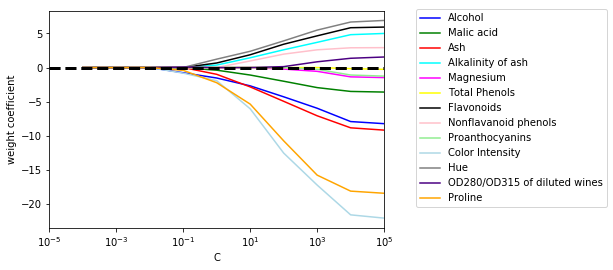

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4.0, 6.0):
    lr = LogisticRegression(penalty='l1', C=10.0**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.0**c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column + 1], color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

The resulting plot provides us with further insights into the behavior of L1 regularisation.  As we can see, all feature weights will be zero if we penalise the model with a strong regularisation parameter (C < 0.1); remember that C is the inverse of the regularisation parameter $\lambda$.

## Sequential Feature Selection algorithms:

In Sequential Backward Selection, we can outline the algorithm in four simple steps.

1.  Initialise the algorithm with $k=d$, where $d$ is the dimensionality of the full feature space $\mathbf{X}_d$.
2.  Determine the feature $\mathbf{x}^{-}$ that maximises the criterion:  $\mathbf{x}^{-} = argmax(J(\mathbf{X}_k - \mathbf{x}))$, where $\mathbf{x} \in \mathbf{X}_k$.
3.  Remove the feature $\mathbf{x}^{-}$ from the feature set:  $\mathbf{X}_{k-1} = \mathbf{X}_k - \mathbf{x}^{-}$, and $k := k - 1$.
4.  Terminate if k equlas the number of desired features; otherwise, go to step 2.

Unfortunately, the SBS algorithm has not been implemented in scikit-learn yet.  But since it is so simple, let us go ahead and implememnt it in Python from scratch:

In [30]:
from sklearn.base import clone  # Constructs a new estimator with the same parameters.
# Clone does a deep copy of the model in an estimator without actually copying attached data.
# It yields a new estimator with the same parameters that has not been fit on any data.
from itertools import combinations
# Return r length subsequences of elements from the input iterable.
# combinations('ABCD', 2) --> AB AC AD BC BD CD
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                                                            random_state=self.random_state)
        
        dim = X_train.shape[1]  # amount of columns / features
        self.indices_ = tuple(range(dim))  # (0, 1, 2, ..., 12)
        self.subsets_ = [self.indices_]  # [(0, 1, 2, ..., 12)]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]

In the preceding implementation, we defined the ```k_features``` parameter to specify the desired number of features we want to return.  By default, we use the ```accuracy_score``` from scikit-learn to evaluate the performance of a model (an estimator for classification) on the feature subsets.

Inside the ```while``` loop of the ```fit``` method, the feature subsets created by the ```itertools.combination``` function are evaluateed and reduced until the feature subset has the desired dimensionality.  In each iteration, the accuracy score of the the best subset is collected in a list, ```self.scores_```, based on the internally created test dataset ```X_test```.  We will use those scores later to evaluate the results.  The column indices of the final feature subset are assigned to ```self.indices```, whcih we can use via the transform method to return a new data array with the selected column features.  Note that, instead of calculating the criterion explicity inside the ```fit``` method, we simply removed the feature that is not contained in the best performing feature subset.

Now let us see our SBS implementation in action using the KNN classifier from scikit-learn:

In [31]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

Remember that our SBS algorithm sollects the scores of the best feature subset at each stage, so let us move on to the more exciting part of our implementation and plot the classification accuracy of the KNN classifer that was calculated on the validation dataset.  The code is as follows:

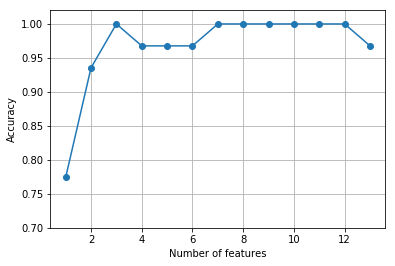

In [32]:
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

As we can see in the resulting figure, the accuracy of the KNN classifier improved on the validation dataset as we recued the number of features, which is likely due to a decrease in the curse of dimensionality that we discussed in the context of the KNN algorithm.  Also, we can see in the following plot that the classifier achieved 100 percent accuracy for $k = \{ 3, 7, 8, 9, 10, 11, 12 \}$.

To satisfy our own curiosity, let's see what the smallest feature subset $(k = 3)$ that yielded such a good performance on the validation dataset looks like.

In [33]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])
print(df_wine.columns)

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')
Index(['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alkalinity of ash',
       'Magnesium', 'Total Phenols', 'Flavonoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color Intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')


Using the preceding code, we obtained the column indices of the three-feaeture subset from the 10th position in the ```sbs.subsets_``` attribute and returned the corresponding feature names from the column-index of the pandas Wine ```DataFrame```.

Next, let us evaluate the performance of the KNN classifier on the original test set.

In [34]:
knn.fit(X_train_std, y_train)
print('Training accuracy: {}'.format(knn.score(X_train_std, y_train)))
print('Test accuracy: {}'.format(knn.score(X_test_std, y_test)))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In the preceding code section we used the complete feature set and obtained approximately 97 percent accuracy on the training dataset and approximately 96 percent on the test, which indictes that our model already generalises well to new data.  

Now, let us use the selected three-feature subset and see how well KNN performs:

In [35]:
knn.fit(X_train_std[:, k3], y_train)
print('Training Accuracy: {}'.format(knn.score(X_train_std[:, k3], y_train)))
print('Test Accuracy: {}'.format(knn.score(X_test_std[:, k3], y_test)))

Training Accuracy: 0.9516129032258065
Test Accuracy: 0.9259259259259259


The Wine dataset is a small dataset, which is very susceptible to randomness - that is, the way we split the dataset into training and test subsets, and how we split the training dataset further into a traiing and valdiation subset.

While we did not increase the performance of the KNN model by reducing the number of features, we shrank the size of the dataset and we obtained a simpler model which is easier to interpret.

## Accessing feature importance with Random Forests.

Using a random forest, we can measure the feature importance as the averaged impurity decrease computed from all decision tresws in the forest, without making any assumptions about whether our data is linearly separable or not.  Conveniently, the random forest implementation in scikit-learn already collects the peature importance values for us so that we can access them via the ```feature_importance_``` attribute after fitting a RandomForestClassifier.  By executing the following code, we will now train a forest of 10,000 trees on the Wine dataset and rank the 13 features by their respective importance measures

 1) Proline                        0.184286
 2) Flavonoids                     0.162783
 3) Color Intensity                0.156836
 4) OD280/OD315 of diluted wines   0.131743
 5) Alcohol                        0.113239
 6) Hue                            0.063972
 7) Total Phenols                  0.053339
 8) Magnesium                      0.032164
 9) Malic acid                     0.027920
10) Alkalinity of ash              0.022981
11) Proanthocyanins                0.022296
12) Nonflavanoid phenols           0.014535
13) Ash                            0.013905


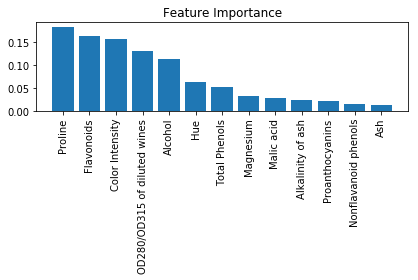

In [36]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("{0:2d}) {1:30s} {2:8.6f}".format(f+1, feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

## Section Conclusion

To conclude this section about feature importance values and random forests, it is worth mentioning that scikit-learn also implements a ```SelectFromModel``` object that selects features based on a user-specified threshlod after model fitting, which is useful if we want to use the ```RandomForestClassifier``` as a feature selector and intermediate step in a scikit-learn ```Pipeline``` object, which allows us to connect different preprocessing steps with an estimator.

For example, we could set the ```threshold``` to ```0.1``` to reduce the dataset to the five most important features using the following code:

In [37]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
# prefit:  bool, default False
# Whether a prefit model is expected to be passed into the constructor directly or not.
# If True, transform must be called directly and SelectFromModel cannot be used with ...
# Otherwise, train the model using fit, and then transform to do feature selection.
X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion: {}'.format(X_selected.shape[0]))

for f in range(X_selected.shape[1]):
    print("{0:2d}) {1:30s} {2:8.6f}".format(f + 1, feat_labels[indices[f]], importances[indices[f]]))

Number of samples that meet this criterion: 124
 1) Proline                        0.184286
 2) Flavonoids                     0.162783
 3) Color Intensity                0.156836
 4) OD280/OD315 of diluted wines   0.131743
 5) Alcohol                        0.113239
